In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import pandas as pd
import numpy as np
import boto3
import json
import seaborn as sns
from credentials.amazon_credentials import amazon_key
import re
import matplotlib.pyplot as plt
import os
import altair as alt
import altair_viewer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import imutils

# True Mean from Todorov Dataset

In [2]:
import pandas as pd
truemean = pd.read_csv('attribute_means.csv')

def true_mean(column, stim): # Expects '2' or '2.jpg' or 2
    stim = str(stim)
    if '.' in stim:
        stim = int(stim.split('.')[0])  # Split by '.' and take the first part
    else:
        stim = int(stim)
    return truemean[column][stim - 1]  # For i+1.jpg, should look for truemean['happy'][i]

result = true_mean('trustworthy', 2)
print(result)

65.0


# Visualize

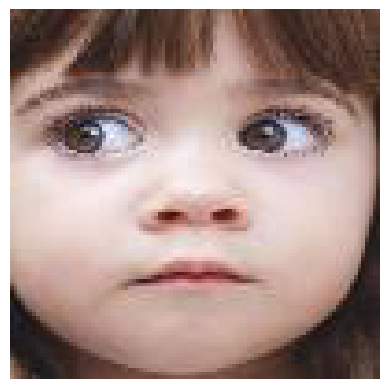

In [3]:
def show_rafdb_img(img_name='test/1/test_0002_aligned.jpg'):
    file_path = os.path.join('rafdb_15k/DATASET', img_name)
    image = plt.imread(file_path)
    plt.imshow(image)
    plt.axis('off')

show_rafdb_img()

# Test Model A, MSE

In [6]:
test_df_names = ['_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_1_rafdb_15k_DATASET_test_1.csv',
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_2_rafdb_15k_DATASET_test_2.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_3_rafdb_15k_DATASET_test_3.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_4_rafdb_15k_DATASET_test_4.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_5_rafdb_15k_DATASET_test_5.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_6_rafdb_15k_DATASET_test_6.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_test_7_rafdb_15k_DATASET_test_7.csv"]
train_df_names = ['_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_1_rafdb_15k_DATASET_train_1.csv',
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_2_rafdb_15k_DATASET_train_2.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_3_rafdb_15k_DATASET_train_3.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_4_rafdb_15k_DATASET_train_4.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_5_rafdb_15k_DATASET_train_5.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_6_rafdb_15k_DATASET_train_6.csv",
"_home_jiheeyou_subjective-output_rafdb_15k_DATASET_train_7_rafdb_15k_DATASET_train_7.csv"]

train, test = pd.DataFrame(), pd.DataFrame()
for tdn in test_df_names:
    test = pd.concat([test, pd.read_csv(f"product/{tdn}")])
test = test.drop(columns='Unnamed: 0')

for trdn in train_df_names:
    train = pd.concat([train, pd.read_csv(f"product/{trdn}")])
train = train.drop(columns='Unnamed: 0')

In [9]:
def test_lasso_mse(train_x, train_y, test_x, test_y):
    # Filter numeric columns
    numeric_train_x = train_x.select_dtypes(include='number')
    numeric_test_x = test_x.select_dtypes(include='number')
    
    scaler = StandardScaler()
        
    train_x_scaled = scaler.fit_transform(numeric_train_x)
    test_x_scaled = scaler.transform(numeric_test_x)
    
    alpha_value = 0.1
    lasso = Lasso(alpha=alpha_value, max_iter=3000)
    lasso.fit(train_x_scaled, train_y)

    train_y_pred = lasso.predict(train_x_scaled)
    test_y_pred = lasso.predict(test_x_scaled)

    train_mse = mean_squared_error(train_y, train_y_pred)
    test_mse = mean_squared_error(test_y, test_y_pred)

    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    return lasso.coef_

test_lasso_mse(train.drop(columns=['label','img_name']), train['label'], test.drop(columns=['label','img_name']), test['label'])

Train MSE: 2.793736880992516, Test MSE: 2.882882086890825


array([-0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.13087438, -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.33341734, -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.11568561, -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

# Test Model A, Categorical

In [5]:
# Surprise, Fear, Disgust, Happiness, Sadness, Anger, Neutral
# 1-7 
def bring_rafdb15k_feats(type='test'):
    df = pd.DataFrame()
    for i in range(1,8):
        section = pd.read_csv(f'product/rafdb_15k_DATASET_{type}_{i}.csv').rename(columns={'Unnamed: 0':'Name'})
        section['label'] = i
        df = pd.concat([df, section])
    return df

full_train = bring_rafdb15k_feats(type='train').reset_index(drop=True)
full_test = bring_rafdb15k_feats(type='test').reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
def test_lasso_ce(train_x, train_y, test_x, test_y):
    # Filter numeric columns
    numeric_train_x = train_x.select_dtypes(include='number')
    numeric_test_x = test_x.select_dtypes(include='number')
    
    scaler = StandardScaler()
        
    train_x_scaled = scaler.fit_transform(numeric_train_x)
    test_x_scaled = scaler.transform(numeric_test_x)

    logistic_regression = LogisticRegression(max_iter=3000)
    param_grid = {
        'C': [0.1, 1, 10, 100], # Regularization parameter
        'solver': ['saga']
    }

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x_scaled, train_y)

    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best hyperparameters:", grid_search.best_params_)

    best_model.fit(train_x_scaled, train_y)
    y_pred = best_model.predict(test_x_scaled)
    conf_matrix = confusion_matrix(test_y, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy:", accuracy)
    best_weights = best_model.coef_
    print("Best Weights:\n", best_weights)
    return best_weights, conf_matrix
    # logistic_regression = LogisticRegression(max_iter=3000)
    # logistic_regression.fit(train_x_scaled, train_y)

    # train_y_pred = logistic_regression.predict(train_x_scaled)
    # test_y_pred = logistic_regression.predict(test_x_scaled)

    # train_accuracy = accuracy_score(train_y, train_y_pred)
    # test_accuracy = accuracy_score(test_y, test_y_pred)

    # print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    # return logistic_regression.coef_, confusion_matrix(test_y, test_y_pred)

w, cm = test_lasso_ce(train.drop(columns=['label','img_name']), train['label'], test.drop(columns=['label','img_name']), test['label'])


/home/jiheeyou/.conda/envs/disc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jiheeyou/.conda/envs/disc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


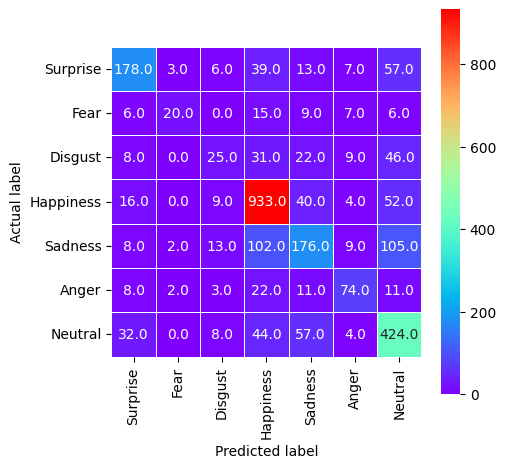

In [11]:
plt.figure(figsize=(5,5))
custom_labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'rainbow',
            yticklabels=custom_labels,xticklabels=custom_labels);
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
# 'Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral'
cm.diagonal() / cm.sum(axis=1)

array([0.58745875, 0.31746032, 0.17730496, 0.88519924, 0.42409639,
       0.5648855 , 0.74516696])

In [9]:
# A lot of data goes missing in dropna
print(len(full_train),len(train))
print(len(full_test),len(test))

12271 7505
3068 1855


# Testing Visualization

## Functions to Run

In [10]:
color_col = ['b0', 'g0', 'r0', 'b1', 'g1', 'r1', 'b2', 'g2', 'r2', 'b3', 'g3', 'r3', 'b4', 'g4', 'r4', 'b5', 'g5', 'r5', 'b6', 'g6', 'r6', 'b7', 'g7', 'r7', 'b8', 'g8', 'r8', 'b9', 'g9', 'r9', 'b10', 'g10', 'r10', 'b11', 'g11', 'r11', 'b12', 'g12', 'r12', 'b13', 'g13', 'r13', 'b14', 'g14', 'r14', 'b15', 'g15', 'r15']
coord_col = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21', 'y21', 'x22', 'y22', 'x23', 'y23', 'x24', 'y24', 'x25', 'y25', 'x26', 'y26', 'x27', 'y27', 'x28', 'y28', 'x29', 'y29', 'x30', 'y30', 'x31', 'y31', 'x32', 'y32', 'x33', 'y33', 'x34', 'y34', 'x35', 'y35', 'x36', 'y36', 'x37', 'y37', 'x38', 'y38', 'x39', 'y39', 'x40', 'y40', 'x41', 'y41', 'x42', 'y42', 'x43', 'y43', 'x44', 'y44', 'x45', 'y45', 'x46', 'y46', 'x47', 'y47', 'x48', 'y48', 'x49', 'y49', 'x50', 'y50', 'x51', 'y51', 'x52', 'y52', 'x53', 'y53', 'x54', 'y54', 'x55', 'y55', 'x56', 'y56', 'x57', 'y57', 'x58', 'y58', 'x59', 'y59', 'x60', 'y60', 'x61', 'y61', 'x62', 'y62', 'x63', 'y63', 'x64', 'y64', 'x65', 'y65', 'x66', 'y66', 'x67', 'y67']
textu_col = ['Angular Second Moment', 'Contrast', 'Correlation', 'Sum of Squares: Variance', 'Inverse Difference Moment', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy', 'Difference Variance', 'Difference Entropy', 'Information Measure of Correlation 1', 'Information Measure of Correlation 2']
w_dict = {key: value for key, value in zip(train.columns.tolist()[1:-1], w[0])} # Only surprise

In [11]:
def visualize_noncoord(dataframe, w_dict=w_dict, index=1):
    df = dataframe.iloc[index]
    plt.figure(figsize=(20, 8))
    
    # Plot texture
    plt.subplot(1, 4, 1)
    plt.bar(x=np.arange(len(textu_col)), height=df[textu_col], color='gray', alpha=0.5)
    plt.bar(x=np.arange(len(textu_col)), width=0.5, height=[w_dict[c] for c in textu_col], color='black') 
        
    for j, height in enumerate([w_dict[c] for c in textu_col]):
        plt.text(j, height+0.5, f'{height:.1f}', ha='center', va='bottom', color='black', size=8)

    plt.xticks(np.arange(len(textu_col)), textu_col, rotation=90)  # Set x-axis ticks with labels and rotation
    plt.yscale('symlog')  # Set y-axis to logarithmic scale
    plt.ylim(-1, 10**4)  # Set y-axis limits starting from 1
    plt.xlabel('Texture Bin')  # Set x-axis label
    plt.ylabel('Texture Intensity, Feature Weight')  # Set y-axis label
    plt.title('Texture')  # Set plot title

    # Plot color
    colors = ['b', 'g', 'r']
    for i, c in enumerate(colors):
        plt.subplot(1, 4, i+2)
        cols = [f'{c}{i}' for i in range(16)]
        
        plt.bar(x=np.arange(16), height=df[cols], color=c, alpha=0.5)
        plt.bar(x=np.arange(16), width=0.5, height=[w_dict[c] for c in cols], color='black') 
        
        for j, height in enumerate([w_dict[c] for c in cols]):
            plt.text(j, height+0.5, f'{height:.1f}', ha='center', va='bottom', color='black', size=8)

        plt.yscale('symlog')  # Set y-axis to logarithmic scale
        plt.xticks(np.arange(16))  # Set x-axis ticks with step size of 1
        plt.ylim(-1, 10**4)  # Set y-axis limits starting from 1
        plt.xlabel('Color Bin')  # Set x-axis label
        plt.ylabel('Color Intensity, Feature Weight')  # Set y-axis label
        plt.title(f'Color {c}')  # Set subplot title

    plt.tight_layout()  # Adjust layout
    plt.show()  # Show plot


In [12]:
def create_coord_df_for_altair(dataframe, index, coord_col):
    df = dataframe.iloc[index]
    name = df['Name']
    df = df[coord_col].reset_index().rename(columns={'index':'point', 2:
                                                     'weight'})
    df['num'] = df['point'].apply(lambda x: int(x[1:]))
    df['dir'] = df['point'].apply(lambda x: x[0])
    df = df.pivot(index='num', columns='dir', values='weight').sort_values(by=['num']).reset_index(drop=True)
    df = df.rename_axis('point')

    df['x_weight'] = [w_dict[f'x{i}'] for i in df.index.tolist()]
    df['y_weight'] = [w_dict[f'y{i}'] for i in df.index.tolist()]

    df = df.reset_index()
    df['point'] = df['point'].astype(str)
    return df, name

def visualize_coord(dataframe, name):
    brush = alt.selection_interval(name='brush')
    base = alt.Chart(dataframe)

    xscale = alt.Scale(domain=(0,500))
    yscale = alt.Scale(domain=(500,0))

    image_chart = alt.Chart().mark_image(
        url=name,  # Using the file path here
        width=500,
        height=500
    ).encode(
        x=alt.value(250),
        y=alt.value(250),
    ).properties(
        width=500,
        height=500
    )

    points = base.mark_circle().encode(
        alt.X("x").scale(xscale),
        alt.Y("y").scale(yscale)
    ).add_params(
    brush
    )
    text = points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='point'
    )

    base_bar = base.mark_bar(binSpacing=0)
    x_hist = (base_bar.encode(
        alt.X("point:Q",scale=alt.Scale(domain=(0, 68))).title("Point"),
        alt.Y("x_weight").stack(None).title("X Weight"),
    )
    .properties(height=150)
    .transform_filter(brush))
    y_hist = (base_bar.encode(
        alt.X("point:Q",scale=alt.Scale(domain=(0, 68))).title("Point"),
        alt.Y("y_weight").stack(None).title("Y Weight"),
    )
    .properties(height=150)
    .transform_filter(brush))
    layered_chart = image_chart + points
    return layered_chart & (x_hist | y_hist)

d, n = create_coord_df_for_altair(test, 1, coord_col)
visualize_coord(d, n)
#visualize_coord(d, n).save('rafdb_test_1_notext.html')

alt.VConcatChart(...)

## Testing Zone

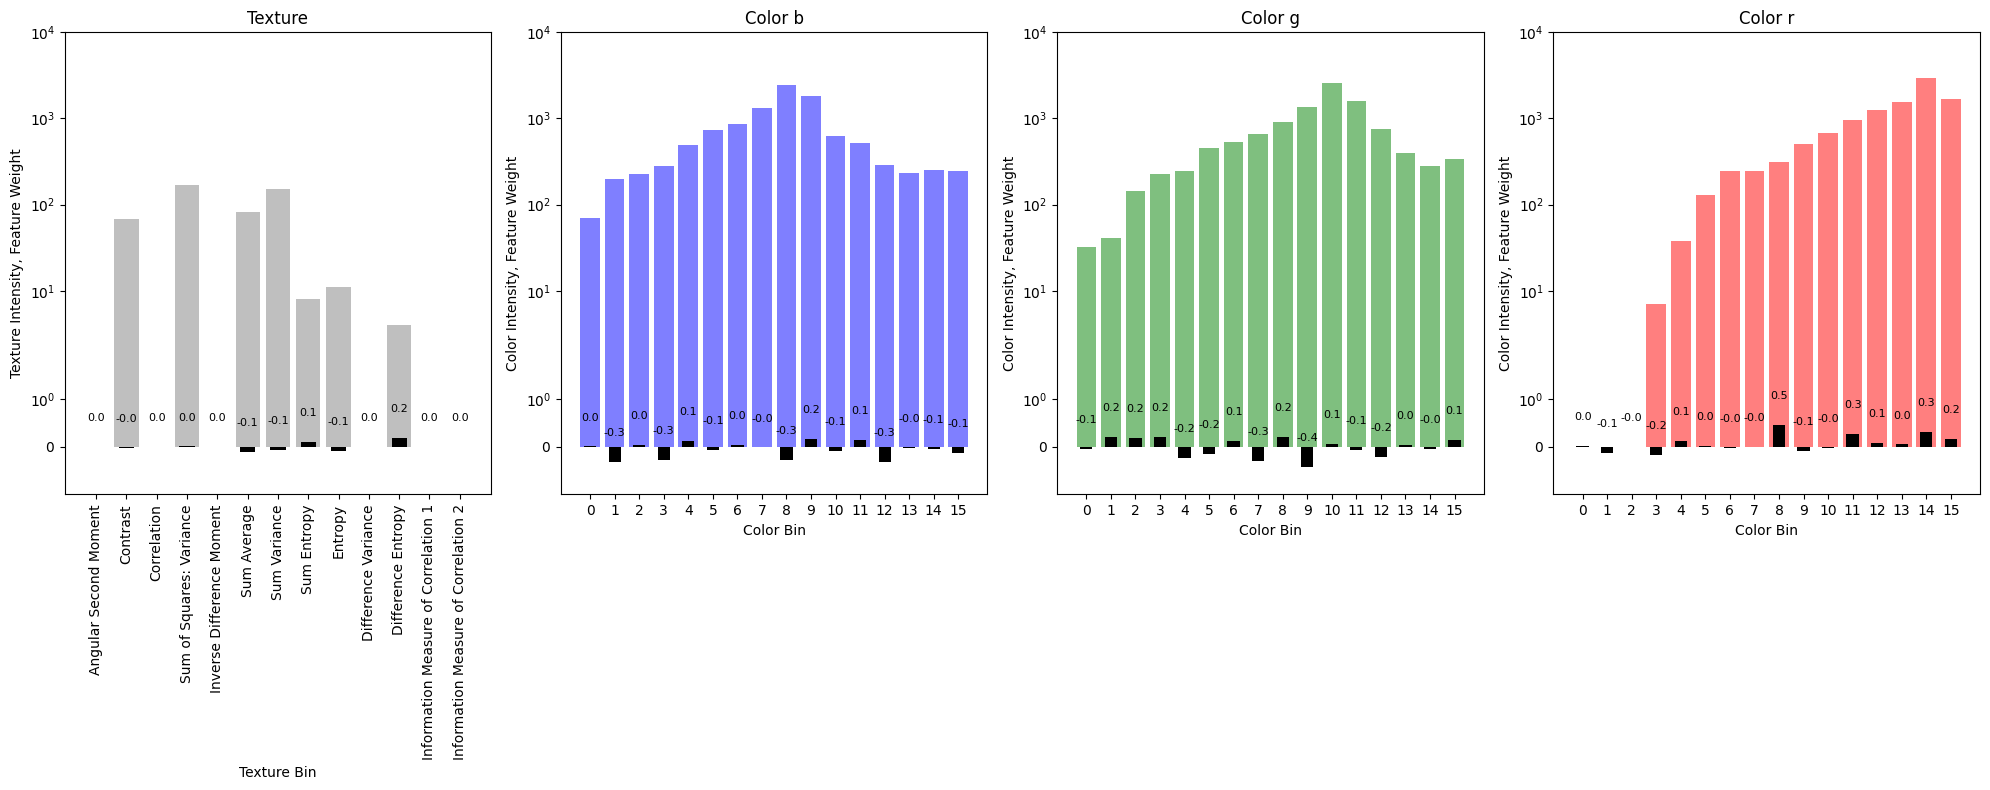

In [13]:
visualize_noncoord(test, index=1)

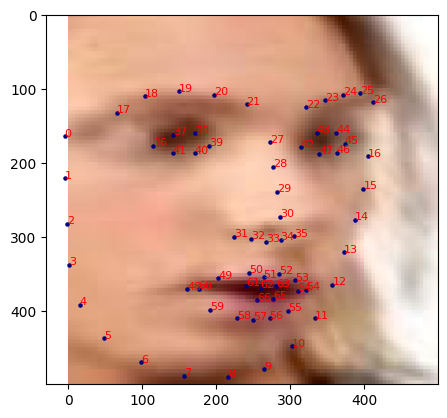

In [14]:
def visualize_coord(dataframe, w_dict=w_dict, index=1):
    df = dataframe.iloc[index]
    file_path = df['Name']
    image = plt.imread(file_path)
    image = imutils.resize(image, width=500)
    plt.imshow(image)

    for i in range(67):
        plt.scatter(df[f'x{i}'], df[f'y{i}'], s = 5,color='navy')
        plt.text(df[f'x{i}'], df[f'y{i}'], str(i), fontsize=8, color='red')  # Annotate each point with its index

    plt.show()

visualize_coord(test)


# Facetorch (Archive)

In [2]:
from facetorch import FaceAnalyzer
from omegaconf import OmegaConf
from torch.nn.functional import cosine_similarity
from typing import Dict
import operator
import torchvision

/home/jiheeyou/.conda/envs/disc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_img_input="./test.jpg"
path_img_output="/test_output.jpg"
path_config="gpu.config.yml"
cfg = OmegaConf.load(path_config)
analyzer = FaceAnalyzer(cfg.analyzer)

{"asctime": "2024-04-03 09:27:04,264", "levelname": "INFO", "message": "Initializing FaceAnalyzer"}
{"asctime": "2024-04-03 09:27:04,265", "levelname": "INFO", "message": "Initializing BaseReader"}
{"asctime": "2024-04-03 09:27:04,524", "levelname": "INFO", "message": "Initializing FaceDetector"}


InstantiationException: Error in call to target 'facetorch.analyzer.detector.core.FaceDetector':
PermissionError(13, 'Permission denied')
full_key: analyzer.detector

In [3]:
analyzer = FaceAnalyzer(cfg.analyzer)

# warmup
response = analyzer.run(
        path_image=path_img_input,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=False,
        include_tensors=True,
        path_output=path_img_output,
    )

{"asctime": "2024-04-03 09:19:29,179", "levelname": "INFO", "message": "Initializing FaceAnalyzer"}
{"asctime": "2024-04-03 09:19:29,180", "levelname": "INFO", "message": "Initializing BaseReader"}
{"asctime": "2024-04-03 09:19:29,195", "levelname": "INFO", "message": "Initializing FaceDetector"}


InstantiationException: Error in call to target 'facetorch.analyzer.detector.core.FaceDetector':
PermissionError(13, 'Permission denied')
full_key: analyzer.detector